In [1]:
import numpy as np
from pandas import Series
import seaborn as sns
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
# Read Excel file and convert it to CSV
excel_file = '../../../Data_Thesis/CNS/Data/Excell_exports/HCL_ST14_ST5B_GOM22SU.XLS'
csv_file = '../../../Data_Thesis/CNS/Data/Areas/GOM22SU_St.14_St.5B_HCL.csv'
df = pd.read_excel(excel_file)
df.to_csv(csv_file, index=False, header=False)

# Read CSV file and create a DataFrame
column_names = ['name', 'file', 'date', 'time', 'type', 'wtd', 'Unnamed_1', 'Unnamed_2', 'Unnamed_3','Unnamed_4', 'N_area', 'C_area', 'S_area']  # Replace with your desired column names
df = pd.read_csv(csv_file, names=column_names)

# Now you can work with the DataFrame
CAMP = "GOM22SU" 
STN = "St.5B"
TREAT = "HCL"
str_id = 'St.5B'

Save_name = '../../../Data_Thesis/CNS/Data/GOM22SU_St.5B_HCL.csv'

In [3]:
df

,name,file,date,time,type,wtd,Unnamed_1,Unnamed_2,Unnamed_3,Unnamed_4,N_area,C_area,S_area
0,Tin,DfchA002,08/04/2023,19:26,By-Pass,NaN,NaN,NaN,NaN,NaN,0.000000,1.986938e+04,0.000000
0,Blank,DfchA003,08/04/2023,19:38,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,2.140327e+04,0.000000
0,Blank,DfchA004,08/04/2023,19:50,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,2.040914e+04,0.000000
0,Blank,DfchA005,08/04/2023,20:02,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,2.013987e+04,0.000000
0,BBOT,DfchA006,08/04/2023,20:14,By-Pass,NaN,NaN,NaN,NaN,NaN,62402.617188,1.569356e+06,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Blank,DfchA065,08/05/2023,08:07,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,4.922940e+05,0.000000
0,Blank,DfchA066,08/05/2023,08:19,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,5.282590e+05,0.000000
0,BBOT,DfchA067,08/05/2023,08:31,By-Pass,NaN,NaN,NaN,NaN,NaN,187474.500000,4.519096e+06,6510.984375
0,CS_Low,DfchA068,08/05/2023,08:43,UNK,1.828,6.25,0.0,NaN,NaN,291838.218750,7.581684e+06,67280.000000


In [4]:
# Calculate mean for rows where type is blank
blank_rows = df[df['type'] == 'Blank']
mean_values = blank_rows[['C_area', 'N_area', 'S_area']].mean()

# Subtract mean from respective columns and create new rows
df['N_area_bl'] = df['N_area']# - mean_values['N_area']
df['C_area_bl'] = df['C_area']# - mean_values['C_area']
df['S_area_bl'] = df['S_area']# - mean_values['S_area']

In [5]:
# Calculate C N S wights 
std = df[df['type'] == 'STD']

# Subtract mean from respective columns and create new rows
std['N_wtd'] = std['wtd'] * .0652
std['C_wtd'] = std['wtd'] * .725
std['S_wtd'] = std['wtd'] * .0746

std

C:\Users\12532\AppData\Local\Temp\ipykernel_2284\2823902847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std['N_wtd'] = std['wtd'] * .0652
C:\Users\12532\AppData\Local\Temp\ipykernel_2284\2823902847.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std['C_wtd'] = std['wtd'] * .725
C:\Users\12532\AppData\Local\Temp\ipykernel_2284\2823902847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,name,file,date,time,type,wtd,Unnamed_1,Unnamed_2,Unnamed_3,Unnamed_4,N_area,C_area,S_area,N_area_bl,C_area_bl,S_area_bl,N_wtd,C_wtd,S_wtd
0,STD_LOW,DfchA007,08/04/2023,20:26,STD,1.191,6.25,0.0,NaN,NaN,199376.921875,4851676.5,21206.5,199376.921875,4851676.5,21206.5,0.077653,0.863475,0.088849
0,STD_MID,DfchA008,08/04/2023,20:38,STD,2.939,6.25,0.0,NaN,NaN,559543.062500,11858343.0,153127.0,559543.062500,11858343.0,153127.0,0.191623,2.130775,0.219249
0,STD_HIGH,DfchA009,08/04/2023,20:50,STD,3.471,6.25,0.0,NaN,NaN,668856.375000,14011010.0,205579.5,668856.375000,14011010.0,205579.5,0.226309,2.516475,0.258937


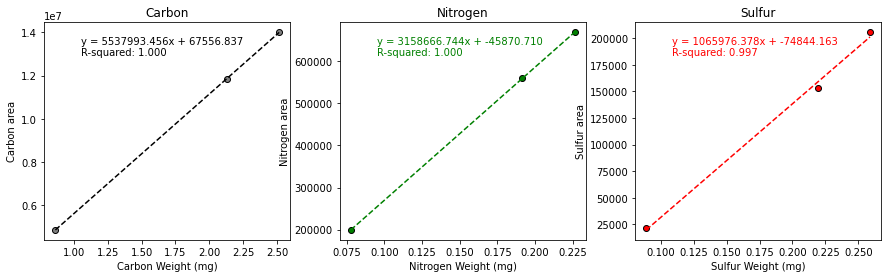

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Scatter plot and linear regression for C_wtd vs C_area
ax = axes[0]
ax.scatter(std['C_wtd'], std['C_area_bl'], facecolor='grey', edgecolor='black')
x = std['C_wtd']
y = std['C_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='black', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Carbon Weight (mg)')
ax.set_ylabel('Carbon area')
ax.set_title('Carbon')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='black')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='black')

# Scatter plot and linear regression for N_wtd vs N_area
ax = axes[1]
ax.scatter(std['N_wtd'], std['N_area_bl'], facecolor='green', edgecolor='black')
x = std['N_wtd']
y = std['N_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='green', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Nitrogen Weight (mg)')
ax.set_ylabel('Nitrogen area')
ax.set_title('Nitrogen')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='green')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='green')

# Scatter plot and linear regression for S_wtd vs S_area
ax = axes[2]
ax.scatter(std['S_wtd'], std['S_area_bl'], facecolor='red', edgecolor='black')
x = std['S_wtd']
y = std['S_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Sulfur Weight (mg)')
ax.set_ylabel('Sulfur area')
ax.set_title('Sulfur')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='red')

# show plot
plt.show()

In [7]:
y = std['C_wtd']
x = std['C_area_bl']
C_coefficients = np.polyfit(x, y, 1)
C_slope = C_coefficients[0]

y = std['N_wtd']
x = std['N_area_bl']
N_coefficients = np.polyfit(x, y, 1)
N_slope = N_coefficients[0]

y = std['S_wtd']
x = std['S_area_bl']
S_coefficients = np.polyfit(x, y, 1)
S_slope = S_coefficients[0]

print(f"SLOPE")
print(f"Carbon slope:   {C_slope}")
print(f"Nitrogen slope: {N_slope}")
print(f"Sulfur slope:   {S_slope}")
print(f"")

# Subtract mean from respective columns and create new rows
df['N_wtd'] = df['N_area_bl'] * N_slope
df['C_wtd'] = df['C_area_bl'] * C_slope
df['S_wtd'] = df['S_area_bl'] * S_slope

# Subtract mean from respective columns and create new rows
df['N%'] = df['N_wtd'] / df['wtd'] *100
df['C%'] = df['C_wtd'] / df['wtd'] *100
df['S%'] = df['S_wtd'] / df['wtd'] *100

cs = df[df['name'].str.contains('CS')]
cs['cs_N%'] = cs['N%']/.0652 
cs['cs_C%'] = cs['C%']/.725 
cs['cs_S%'] = cs['S%']/.0746 

#ca = df[df['name'].str.contains('Ca')]
#ca['ca_C%'] = ca['C%']/.1199 

print(f"Check Standerd % est")
print('Nitrogen')
print(cs['cs_N%'])
print('Carbon')
print(cs['cs_C%'])
print('Sulfer')
print(cs['cs_S%'])
#print('CaCO3')
#print(ca['ca_C%'])


SLOPE
Carbon slope:   1.8057024141058067e-07
Nitrogen slope: 3.1658918452271214e-07
Sulfur slope:   9.352914218014344e-07

Check Standerd % est
Nitrogen
0    77.520123
0    86.713633
Name: cs_N%, dtype: float64
Carbon
0    103.299360
0    101.819327
Name: cs_C%, dtype: float64
Sulfer
0     46.144284
0    100.471346
Name: cs_S%, dtype: float64


C:\Users\12532\AppData\Local\Temp\ipykernel_2284\3620005721.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['cs_N%'] = cs['N%']/.0652
C:\Users\12532\AppData\Local\Temp\ipykernel_2284\3620005721.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['cs_C%'] = cs['C%']/.725
C:\Users\12532\AppData\Local\Temp\ipykernel_2284\3620005721.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [8]:
ds = df[df['name'].str.contains(str_id)]
ds['ID'] = ds['name'].str[-2:]
ds['Treat'] = TREAT
ds['Camp'] = CAMP
ds['Station'] = STN
ds['notes'] = "1 Sulfer CS bad"

selected_columns = ['ID', 'Treat', 'Camp', 'Station', 'N%', 'C%', 'S%', 'notes']
ds = ds[selected_columns]

ds.to_csv(Save_name, index=False, header=True)
ds

C:\Users\12532\AppData\Local\Temp\ipykernel_2284\2250568272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['ID'] = ds['name'].str[-2:]
C:\Users\12532\AppData\Local\Temp\ipykernel_2284\2250568272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['Treat'] = TREAT
C:\Users\12532\AppData\Local\Temp\ipykernel_2284\2250568272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,ID,Treat,Camp,Station,N%,C%,S%,notes
0,01,HCL,GOM22SU,St.5B,0.072563,0.595477,0.000000,1 Sulfer CS bad
0,02,HCL,GOM22SU,St.5B,0.078073,0.642040,0.000000,1 Sulfer CS bad
0,03,HCL,GOM22SU,St.5B,0.040929,0.103320,0.000000,1 Sulfer CS bad
0,04,HCL,GOM22SU,St.5B,0.060650,0.494290,0.000000,1 Sulfer CS bad
0,05,HCL,GOM22SU,St.5B,0.071668,0.589242,0.036642,1 Sulfer CS bad
0,06,HCL,GOM22SU,St.5B,0.083570,0.690657,0.052907,1 Sulfer CS bad
0,07,HCL,GOM22SU,St.5B,0.083958,0.730286,0.056258,1 Sulfer CS bad
0,08,HCL,GOM22SU,St.5B,0.084680,0.727186,0.000000,1 Sulfer CS bad
0,09,HCL,GOM22SU,St.5B,0.062944,0.564122,0.057089,1 Sulfer CS bad
0,10,HCL,GOM22SU,St.5B,0.056307,0.493729,0.000000,1 Sulfer CS bad
